## JPEG 压缩

-----
参考
* [DCT变换](https://blog.csdn.net/qq_29573053/article/details/78436325)
* [JPEG压缩](https://blog.csdn.net/nemoyy/article/details/80896449)
* [DCT变换与图像压缩](https://zhaoxuhui.top/blog/2018/05/26/DCTforImageDenoising.html#2%E4%BA%8C%E7%BB%B4dct%E5%8F%98%E6%8D%A2fdct)

[https://blog.csdn.net/James_Ray_Murphy/article/details/79173388](https://blog.csdn.net/James_Ray_Murphy/article/details/79173388)

-----
* JEPG不是一种文件格式,而是一类**图像压缩算法**

* 其流程如下：
![JPEG压缩流程](pic/JPEG.png)

###  Q36 第一步：离散余弦变换（Discrete Cosine Transformation）

灰度化之后，先进行离散余弦变换，再进行离散余弦逆变换吧  

DCT

* DCT变换的全称是离散余弦变换(Discrete Cosine Transform)，主要用于将数据或图像的压缩，能够将空域的信号转换到频域上，具有良好的去相关性的性能

#### 一维DCT变换

$$
F(u)=c(u) \sum_{i=0}^{N-1} f(i) \cos \left[\frac{(i+0.5) \pi}{N} u\right]
$$

$$
c(u)=\left\{\begin{array}{l}{\sqrt{\frac{1}{N}}, u=0} \\ {\sqrt{\frac{2}{N}}, u \neq 0}\end{array}\right.
$$

其中，f(i)为原始的信号，F(u)是DCT变换后的系数，N为原始信号的点数，c(u)可以认为是一个补偿系数，可以使DCT变换矩阵为正交矩阵

#### 二维DCT变换
$$
\begin{array}{l}{F(u, v)=c(u) c(v) \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} f(i, j) \cos \left[\frac{(i+0.5) \pi}{N} u\right] \cos \left[\frac{(j+0.5) \pi}{N} v\right]} \\ {c(u)=\left\{\begin{array}{l}{\sqrt{\frac{1}{N}}, u=0} \\ {\sqrt{\frac{2}{N}}, u \neq 0}\end{array}\right.}\end{array}
$$


* 将图像高频的信息和低频的信息区分开来, 并将人眼不敏感的低频信息映射到接近或等于0

* **矩阵形式**
$$
\begin{array}{l}{F=A f A^{T}} \\ {A(i, j)=c(i) \cos \left[\frac{(j+0.5) \pi}{N} i\right]}\end{array}
$$

----

### Q37 PSNR

离散余弦逆变换中如果不使用8作为系数，而是使用4作为系数的话，图像的画质会变差  

*求输入图像和经过离散余弦逆变换之后的图像的峰值信噪比，离散余弦逆变换的比特率*

-----
#### 峰值信噪比
* 峰值信噪比（Peak Signal to Noise Ratio）缩写为PSNR，用来表示信号最大可能功率和影响它的表示精度的破坏性噪声功率的比值，可以显示图像画质损失的程度

* 峰值信噪比越大，表示画质损失越小

定义如下：
```
PSNR = 10 * log10(MAX^2 / MSE)
MSE = Sum_{y=0:H-1} Sum_{x=0:W-1} (I1(x,y) - I2(x,y))^2 / (HW)
```
MSE表示均方误差（Mean Squared Error），用来表示两个图像各个像素点之间差值平方和的平均数  

-----
#### 比特率
如果我们进行TxT的离散余弦变换，离散余弦逆变换的系数为KxK的话，比特率按下式定义：

```
bitrate = T * K^2 / T^2

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

PSNR : 27.64984189788171 
bitrate : 2.0


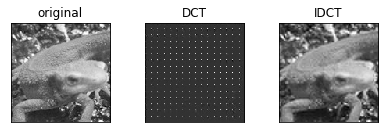

In [2]:
img = cv2.imread("gg.jpg")
img_origin = img.copy()

img = img.astype(np.float32)

(H, W, C) = img.shape

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# DCT
T = 8
# idct 系数 8
K = 4
X = np.zeros((H, W), dtype=np.float32)

def w(x, y, u, v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    return ((2 * cv * cu / T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))

# DCT
for yi in range(0, H, T):
    for xi in range(0, W, T):
        for v in range(T):
            for u in range(T):
                for y in range(T):
                    for x in range(T):
                        X[v + yi, u + xi] += gray[y+yi, x+xi] * w(x,y,u,v)

# iDCT
img_out = np.zeros((H, W), dtype=np.float32)

for yi in range(0, H, T):
    for xi in range(0, W, T):
        for y in range(T):
            for x in range(T):
                for v in range(K):
                    for u in range(K):
                        img_out[yi + y, xi + x] += X[v+yi, u+xi] * w(x, y, u, v)

img_out[img_out > 255] = 255
img_out = img_out.astype(np.uint8)

# caculate rsnr and bitrate
v_max = 255.
MSE = np.sum((gray.astype(np.float32) - img_out.astype(np.float32))**2) / (H * W)
PSNR = 10 * np.log10(v_max ** 2 / MSE)
bitrate = 1. * T * K ** 2 / (T ** 2)
print("PSNR :", PSNR,
     "\nbitrate :", bitrate)

img_origin = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)

plt.subplot(131)
plt.imshow(gray, cmap='gray')
plt.title('original'),plt.xticks([]),plt.yticks([])

plt.subplot(132)
plt.imshow(X, cmap='gray')
plt.title('DCT'),plt.xticks([]),plt.yticks([])

plt.subplot(133)
plt.imshow(img_out, cmap='gray')
plt.title('IDCT'),plt.xticks([]),plt.yticks([])
plt.subplots_adjust(top=1.2, bottom=0.08, left=0.10, right=0.95, 
                    hspace=0.25, wspace=0.35)
plt.show()

### Q38 第二步：离散余弦变换+量化

------
[量化](https://blog.csdn.net/jacke121/article/details/80434813)

------

量化离散余弦变换系数并使用 离散余弦逆变换恢复。再比较变换前后图片的大小  
量化离散余弦变换系数是用于编码 JPEG 图像的技术  
量化即在对值在预定义的区间内舍入，其中`floor、ceil、round`等是类似的计算

在 JPEG 图像中，根据下面所示的量化矩阵量化离散余弦变换系数。该量化矩阵取自 JPEG 软件开发联合会组织颁布的标准量化表。在量化中，将8x 8的系数除以（量化矩阵） Q 并四舍五入。之后然后再乘以 Q 。对于离散余弦逆变换，应使用所有系数  

JPEG系统分别规定了**亮度分量**和**色度分量**的量化表，色度分量相应的量化步长比亮度分量大。

*　亮度量化表
```
Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
              (12, 12, 14, 19, 26, 58, 60, 55),
              (14, 13, 16, 24, 40, 57, 69, 56),
              (14, 17, 22, 29, 51, 87, 80, 62),
              (18, 22, 37, 56, 68, 109, 103, 77),
              (24, 35, 55, 64, 81, 104, 113, 92),
              (49, 64, 78, 87, 103, 121, 120, 101),
              (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)
```
整个过程中的主要有损运算  
经常会把很多高频率的成份四舍五入而接近0，且剩下很多会变成小的正或负数


PSNR : 30.559073141991448 
bitrate : 8.0


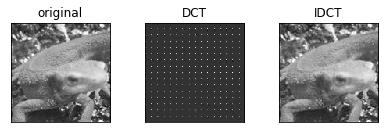

In [3]:
img = cv2.imread("gg.jpg")
img_origin = img.copy()

img = img.astype(np.float32)

(H, W, C) = img.shape

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# DCT
T = 8
# idct 系数 8
K = 8
X = np.zeros((H, W), dtype=np.float64)
Q = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
              (12, 12, 14, 19, 26, 58, 60, 55),
              (14, 13, 16, 24, 40, 57, 69, 56),
              (14, 17, 22, 29, 51, 87, 80, 62),
              (18, 22, 37, 56, 68, 109, 103, 77),
              (24, 35, 55, 64, 81, 104, 113, 92),
              (49, 64, 78, 87, 103, 121, 120, 101),
              (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)

def w(x, y, u, v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    return ((2 * cv * cu / T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))

# DCT
for yi in range(0, H, T):
    for xi in range(0, W, T):
        for v in range(T):
            for u in range(T):
                for y in range(T):
                    for x in range(T):
                        X[v + yi, u + xi] += gray[y+yi, x+xi] * w(x,y,u,v)
        X[yi: yi + T, xi: xi + T] = np.round(X[yi: yi + T, xi: xi + T] / Q) * Q

        # 每份8*8的矩阵除以量化矩阵Q，然后再四舍五入，获得量化后的结果
        
# iDCT
img_out = np.zeros((H, W), dtype=np.float64)

for yi in range(0, H, T):
    for xi in range(0, W, T):
        for y in range(T):
            for x in range(T):
                for v in range(K):
                    for u in range(K):
                        img_out[yi + y, xi + x] += X[v+yi, u+xi] * w(x, y, u, v)

img_out[img_out > 255] = 255
img_out = img_out.astype(np.uint8)

# caculate rsnr and bitrate
v_max = 255.
MSE = np.sum((gray.astype(np.float32) - img_out.astype(np.float32))**2) / (H * W)
PSNR = 10 * np.log10(v_max ** 2 / MSE)
bitrate = 1. * T * K ** 2 / (T ** 2)
print("PSNR :", PSNR,
     "\nbitrate :", bitrate)

img_origin = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)

plt.subplot(131)
plt.imshow(gray, cmap='gray')
plt.title('original'),plt.xticks([]),plt.yticks([])

plt.subplot(132)
plt.imshow(X, cmap='gray')
plt.title('DCT'),plt.xticks([]),plt.yticks([])

plt.subplot(133)
plt.imshow(img_out, cmap='gray')
plt.title('IDCT'),plt.xticks([]),plt.yticks([])
plt.subplots_adjust(top=1.2, bottom=0.08, left=0.10, right=0.95, 
                    hspace=0.25, wspace=0.35)
plt.show()

### Q39第三步：YCbCr 色彩空间

在 YCbCr 色彩空间内，将 Y 乘以0.7以使对比度变暗  

YCbCr 色彩空间是用于将图像由表示亮度的 Y、表示蓝色色度Cb以及表示红色色度Cr表示的方法。

这用于 JPEG 转换
* 使用下式从 RGB 转换到 YCbCr：
```
Y = 0.299 * R + 0.5870 * G + 0.114 * B
Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
Cr = 0.5 * R - 0.4187 * G - 0.0813 * B + 128
```

* 使用下式从 YCbCr 转到 RGB：

```
R = Y + (Cr - 128) * 1.402
G = Y - (Cb - 128) * 0.3441 - (Cr - 128) * 0.7139
B = Y + (Cb - 128) * 1.7718
```


### Q40 第四步：YCbCr+离散余弦变换+量化
将图像转为YCbCr色彩空间之后，进行 离散余弦变换再对 Y 用 Q1 量化矩阵量化，Cb 和 Cr 用 Q2 量化矩阵量化。最后通过离散余弦逆变换对图像复原


PSNR : 29.41772673630261 
bitrate : 8.0


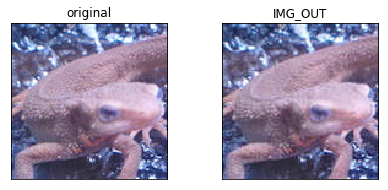

In [4]:
img = cv2.imread("gg.jpg")
img_origin = img.copy()

img = img.astype(np.float32)

(H, W, C) = img.shape

(B, G, R) = cv2.split(img)

# BGR2YCbCr
Y = 0.299 * R + 0.5870 * G + 0.114 * B
Cb = -0.1687 * R - 0.3313 * G + 0.5 * B + 128
Cr = 0.5 * R - 0.4187 * G - 0.0813 * B + 128

# DCT
T = 8
# idct 系数 8
K = 8
X_Y  = np.zeros((H, W), dtype=np.float64)
X_Cb = np.zeros((H, W), dtype=np.float64)
X_Cr = np.zeros((H, W), dtype=np.float64)


Q1 = np.array(((16, 11, 10, 16, 24, 40, 51, 61),
               (12, 12, 14, 19, 26, 58, 60, 55),
               (14, 13, 16, 24, 40, 57, 69, 56),
               (14, 17, 22, 29, 51, 87, 80, 62),
               (18, 22, 37, 56, 68, 109, 103, 77),
               (24, 35, 55, 64, 81, 104, 113, 92),
               (49, 64, 78, 87, 103, 121, 120, 101),
               (72, 92, 95, 98, 112, 100, 103, 99)), dtype=np.float32)

Q2 = np.array(((17, 18, 24, 47, 99, 99, 99, 99),
               (18, 21, 26, 66, 99, 99, 99, 99),
               (24, 26, 56, 99, 99, 99, 99, 99),
               (47, 66, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99),
               (99, 99, 99, 99, 99, 99, 99, 99)), dtype=np.float32)

def w(x, y, u, v):
    cu = 1.
    cv = 1.
    if u == 0:
        cu /= np.sqrt(2)
    if v == 0:
        cv /= np.sqrt(2)
    theta = np.pi / (2 * T)
    return ((2 * cv * cu / T) * np.cos((2*x+1)*u*theta) * np.cos((2*y+1)*v*theta))

# DCT
for yi in range(0, H, T):
    for xi in range(0, W, T):
        for v in range(T):
            for u in range(T):
                for y in range(T):
                    for x in range(T):
                        X_Y[v + yi, u + xi]  += Y[y+yi, x+xi] * w(x,y,u,v)
                        X_Cb[v + yi, u + xi] += Cb[y+yi, x+xi] * w(x,y,u,v)
                        X_Cr[v + yi, u + xi] += Cr[y+yi, x+xi] * w(x,y,u,v)
        X_Y[yi: yi + T, xi: xi + T]  = np.round(X_Y[yi: yi + T, xi: xi + T] / Q1) * Q1
        X_Cb[yi: yi + T, xi: xi + T] = np.round(X_Cb[yi: yi + T, xi: xi + T] / Q2) * Q2
        X_Cr[yi: yi + T, xi: xi + T] = np.round(X_Cr[yi: yi + T, xi: xi + T] / Q2) * Q2

        # 每份8*8的矩阵除以量化矩阵Q，然后再四舍五入，获得量化后的结果

# iDCT
img_out = np.zeros((H, W, C), dtype=np.float64)
Y_out  = np.zeros((H, W), dtype=np.float64)
Cb_out = np.zeros((H, W), dtype=np.float64)
Cr_out = np.zeros((H, W), dtype=np.float64)

for yi in range(0, H, T):
    for xi in range(0, W, T):
        for y in range(T):
            for x in range(T):
                for v in range(K):
                    for u in range(K):
                        Y_out[yi + y, xi + x] += X_Y[v+yi, u+xi] * w(x, y, u, v)
                        Cb_out[yi + y, xi + x] += X_Cb[v+yi, u+xi] * w(x, y, u, v)
                        Cr_out[yi + y, xi + x] += X_Cr[v+yi, u+xi] * w(x, y, u, v)
# YCbCr > BGR
img_out[..., 0] = Y_out + (Cb_out - 128) * 1.7718
img_out[..., 1] = Y_out - (Cb_out - 128) * 0.3441 - (Cr_out - 128) * 0.7139
img_out[..., 2] = Y_out + (Cr_out - 128) * 1.402

img_out[img_out > 255] = 255
img_out = img_out.astype(np.uint8)

v_max = 255.
MSE = np.sum((img.astype(np.float32) - img_out.astype(np.float32))**2) / (H * W * C)
PSNR = 10 * np.log10(v_max ** 2 / MSE)
bitrate = 1. * T * K ** 2 / (T ** 2)
print("PSNR :", PSNR,
     "\nbitrate :", bitrate)

img_origin = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)

plt.subplot(121)
plt.imshow(img_origin)
plt.title('original'),plt.xticks([]),plt.yticks([])

plt.subplot(122)
plt.imshow(img_out)
plt.title('IMG_OUT'),plt.xticks([]),plt.yticks([])
plt.subplots_adjust(top=1.2, bottom=0.08, left=0.10, right=0.95, 
                    hspace=0.25, wspace=0.35)
plt.show()

## opencv 实现DCT

---
* [https://blog.csdn.net/leviopku/article/details/86512468](https://blog.csdn.net/leviopku/article/details/86512468)

```
cv2.dct()
```

* 将数值精度调整为32位浮点型
* `cv2.dct`只支持单通道


逆余弦变换
```
cv2.idct()
```

PSNR : 141.9031932747438 
bitrate : 8.0


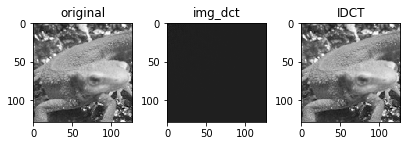

In [5]:
img = cv2.imread("gg.jpg")
img_origin = img.copy()


img = np.float32(img)

# DCT
T = 8
gary = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_dct = cv2.dct(gray)
img_recor = cv2.idct(img_dct)

v_max = 255.
MSE = np.sum((gray.astype(np.float32) - img_recor.astype(np.float32))**2) / (H * W)
PSNR = 10 * np.log10(v_max ** 2 / MSE)
bitrate = 1. * T * K ** 2 / (T ** 2)
print("PSNR :", PSNR,
     "\nbitrate :", bitrate)

plt.subplot(131)
plt.imshow(gray, cmap='gray')
plt.title('original')

plt.subplot(132)
plt.imshow(img_dct, cmap='gray')
plt.title('img_dct')

plt.subplot(133)
plt.imshow(img_recor, cmap='gray')
plt.title('IDCT')
plt.subplots_adjust(top=1.2, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

## opencv 实现图像JPEG压缩

-----

* [opencv c++](https://blog.csdn.net/qikaihuting/article/details/84998156)
* [自己实现JPEG压缩](https://blog.csdn.net/c980129/article/details/88263654)

* [https://codeday.me/bug/20190324/817276.html](https://codeday.me/bug/20190324/817276.html)

[encode](https://blog.csdn.net/m0_37407756/article/details/80020560)
 
-----
主要是用到了cv::imencode和cv::imdecode两个函数

128
origin img size:  49280 
encode img size:  7948 
decode img size:  49280


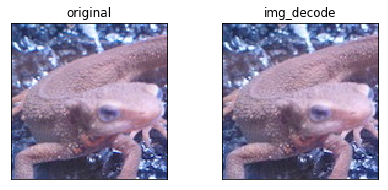

In [6]:
import sys
img = cv2.imread("gg.jpg")
img_origin = img.copy()
print(img.shape[0])

encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90]
# '.jpg'表示把当前图片img按照jpg格式编码，按照不同格式编码的结果不一样  
result, encimg = cv2.imencode('.jpg', img, encode_param)
# imgg = cv2.imencode('.png', img) 

data_encode = np.array(encimg)  
str_encode = data_encode.tostring() #data_encode.tobytes()
# print(str_encode)

# 解码
# nparr = np.fromstring(str_encode, np.uint8) 
nparr = np.asarray(bytearray(str_encode), dtype="uint8")  
img_decode = cv2.imdecode(nparr, cv2.IMREAD_COLOR)


img_origin = cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB)
img_decode = cv2.cvtColor(img_decode, cv2.COLOR_BGR2RGB)

# 变量所占字节数
print("origin img size: ", sys.getsizeof(img),
     "\nencode img size: ", sys.getsizeof(str_encode),
     "\ndecode img size: ", sys.getsizeof(img_decode))

plt.subplot(121)
plt.imshow(img_origin)
plt.title('original'),plt.xticks([]),plt.yticks([])

plt.subplot(122)
plt.imshow(img_decode)
plt.title('img_decode'),plt.xticks([]),plt.yticks([])
plt.subplots_adjust(top=1.2, bottom=0.08, left=0.10, right=0.95, 
                    hspace=0.25, wspace=0.35)
plt.show()